In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import sys
from pathlib import Path
import subprocess
from platformdirs import user_cache_dir
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

import ms_pred.common as common
from ms_pred.dag_pred.iceberg_elucidation import candidates_from_pubchem, iceberg_prediction, load_real_spec, load_pred_spec, elucidation_over_candidates, plot_top_mols, explain_peaks, modi_finder, generate_buyable_report, load_global_config

/home/roger/miniforge3/envs/ms-main/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# go to workingdir/ms-pred
%cd ~/ms-pred

/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred


# Global configs
Please modify the configs in `configs/iceberg/iceberg_elucidation.yaml` accordingly. If your hostname is ``server1``, create a new entry named ``server1``, and specify all the parameters as shown in the example.

In [3]:
config = load_global_config()

## Withanolide

In [4]:
def spec_from_csv(csv_paths, precursor, colli_eng='collision 30', ppm=20):
    clean_ref_spec = None
    for csv_path in csv_paths:
        spec_df = pd.read_csv(csv_path, header=1)
        ref_spec = common.process_spec_file({'parentmass': precursor}, [(colli_eng, np.array(spec_df))], merge_specs=False)
        if clean_ref_spec is None:
            clean_ref_spec = ref_spec
        else:
            new_clean_peaks = []
            for mz, inten in clean_ref_spec[colli_eng]:
                match = np.abs(mz - ref_spec[colli_eng][:, 0]) / mz < 1e-6 * ppm  # only keep peaks that exist in all replicates
                if np.any(match):
                    otherinten = ref_spec[colli_eng][np.where(match), 1]
                    new_clean_peaks.append((mz, inten + otherinten.item()))
            clean_ref_spec = {colli_eng: np.array(new_clean_peaks)}
    clean_ref_spec[colli_eng][:, 1] /= np.max(clean_ref_spec[colli_eng][:, 1])
    return clean_ref_spec

def mol_ok(mol):
    try:
        Chem.SanitizeMol(mol)
        return True
    except ValueError:
        return False

def ring_OK(mol):
    if not mol.HasSubstructMatch(Chem.MolFromSmarts("[R]")):
        return True

    ring_allene = mol.HasSubstructMatch(Chem.MolFromSmarts("[R]=[R]=[R]"))

    cycle_list = mol.GetRingInfo().AtomRings()
    max_cycle_length = max([len(j) for j in cycle_list])
    macro_cycle = max_cycle_length > 6

    double_bond_in_small_ring = mol.HasSubstructMatch(
        Chem.MolFromSmarts("[r3,r4]=[r3,r4]")
    )

    return not ring_allene and not macro_cycle and not double_bond_in_small_ring

def generate_candidates(base_mols, all_rxn_smarts):
    iterable = True
    try:
        _ = iter(base_mols)
    except TypeError as te:
        iterable = False

    if not iterable:
        base_mols = [base_mols]

    candidate_pathways = []
    all_new_mols = []
    for rxn_smarts in all_rxn_smarts:
        rxn = AllChem.ReactionFromSmarts(rxn_smarts)
        for base_mol in base_mols:
            new_mol_trial = rxn.RunReactants((base_mol,))
            new_mols = np.array([mol[0] for mol in new_mol_trial if mol_ok(mol[0]) and ring_OK(mol[0])])
            new_inchikey = np.array([Chem.MolToInchiKey(mol) for mol in new_mols])
            _, indices = np.unique(new_inchikey, return_index=True)
            new_mols = new_mols[indices]
            candidate_pathways += [(Chem.MolToSmiles(base_mol), Chem.MolToSmiles(m)) for m in new_mols]
            all_new_mols += new_mols.tolist()

    new_inchikey = np.array([Chem.MolToInchiKey(mol) for mol in all_new_mols])
    _, indices = np.unique(new_inchikey, return_index=True)
    all_new_mols = np.array(all_new_mols)[indices]
    return all_new_mols, candidate_pathways

def add_atom(base_mols, new_atom='O'):  # Hydrogen is ignored, new_atom='C' means 'CH2'
    all_rxn_smarts = [
        "[*:1]>>[*:1]X".replace("X", new_atom),  # append
        # "[*:1]-[*:2]>>[*:1]X[*:2]".replace("X", new_atom),  # insert
    ]
    if new_atom == 'O':
        all_rxn_smarts.append(
            "[*:1]=[*:2]>>[*:1]1X[*:2]1".replace("X", new_atom),  # double bond -> C-O-C ring
        )
    return generate_candidates(base_mols, all_rxn_smarts)

def add_unsaturation(base_mols):  # add double bond or add one ring
    all_rxn_smarts = [
        "[*:1]-[*:2]>>[*:1]=[*:2]",  # single bond -> double bond
        "[*:1]=[*:2]>>[*:1]#[*:2]",  # double bond -> triple bond
        "[*;!r;!H0:1]~[*;!r:2]~[*;!r;!H0:3]>>[*:1]1~[*:2]~[*:3]1",  # rings
        "[*;!r;!H0:1]~[*!r:2]~[*!r:3]~[*;!r;!H0:4]>>[*:1]1~[*:2]~[*:3]~[*:4]1",
        "[*;!r;!H0:1]~[*!r:2]~[*:3]~[*:4]~[*;!r;!H0:5]>>[*:1]1~[*:2]~[*:3]~[*:4]~[*:5]1",
        "[*;!r;!H0:1]~[*!r:2]~[*:3]~[*:4]~[*!r:5]~[*;!r;!H0:6]>>[*:1]1~[*:2]~[*:3]~[*:4]~[*:5]~[*:6]1",
    ]
    return generate_candidates(base_mols, all_rxn_smarts)

def withanolide_elucidation(meta, visual_peaks=False):
    withanolide_config = copy.deepcopy(config)
    withanolide_config['real_spec_type'] = 'raw'
    withanolide_config['adduct'] = meta["adduct"]

    # Run ICEBERG to predict spectra
    result_path, pmz = iceberg_prediction(meta["candidate_smiles"], [30], **withanolide_config)

    # Compare spectrum similarity for elucidation
    topk_results = elucidation_over_candidates(result_path, meta["ref_spec"], precursor_mass=pmz, mol_name=meta["cmpd_name"], topk=30, **withanolide_config)

    # Plot top results
    img = plot_top_mols(topk_results)

    # Visualize and explain peaks
    if visual_peaks:
        if 'real_smi' in meta:
            all_smiles = [meta['real_smi']]
        else:
            all_smiles = meta["candidate_smiles"]
        for smi in all_smiles:
            explain_peaks(result_path, meta["ref_spec"], pmz, smi, num_peaks=50, save_path=meta["cmpd_name"] + '_peak_explainer.pdf', **withanolide_config)

    return img

## Structures and candidates

In [5]:
cmpd22_smi = common.rm_stereo(r'C[C@]12C(C[C@@H](O)CC2)=CC[C@]3([H])[C@]1([H])CC[C@@]4(C)[C@@]3([H])CC[C@@H]4[C@H](C)CC/C(=C)C(C)/C')
cmpd23_smi = common.rm_stereo(r'C[C@]12C(C[C@@H](O)CC2)=CC[C@]3([H])[C@]1([H])CC[C@@]4(C)[C@@]3([H])CC[C@@H]4[C@H](C)CC/C(C)=C(C)/C')
cmpd24_smi = common.rm_stereo(r'C[C@]12C(C[C@@H](O)CC2)=CC[C@]3([H])[C@]1([H])CC[C@@]4(C)[C@@]3([H])CC[C@@H]4[C@H](C)[C@H](O)C/C(C)=C(C)/C')
cmpd26_smi = common.rm_stereo(r'CC(C)=C(C)CC(O)C(C)C1CCC2C3CC=C4CC(O)CC(O)C4(C)C3CCC12C')
cmpd27_smi = common.rm_stereo(r'C[C@]12C(C[C@@H](O)C[C@@H]2O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)[C@H](O)C/C(C)=C(CO)/C')
cmpd28_smi = common.rm_stereo(r'C[C@]12C(C[C@@H](O)C[C@@H]2O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C5OC(O)C(C)=C(C)C5')
cmpd29_smi = common.rm_stereo(r'C[C@]12C(C[C@@H](O)CC2O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C5OC(C(C)=C(C)C5)=O')

withanolide_meta = {}

withanolide_meta['24mcol'] = {
    "cmpd_name": "24mcol",
    "precursor": 381.3514,
    "adduct": '[M+H-H2O]+',
    "spec_name": '24mcol-ms2',
    "replicate_suffix": (None,),
    "candidate_smiles": [cmpd22_smi],
    "real_smi": cmpd22_smi,
}

withanolide_meta['24mdes'] = {
    "cmpd_name": "24mdes",
    "precursor": 381.3492126,
    "adduct": '[M+H-H2O]+',
    "spec_name": '24mdes-rmlabel-ms2', # This standard was C-13 labeled. We used ICEBERG to predict fragments, and then remove the C-13 label by fragment predictions
    "replicate_suffix": (None,),
    "candidate_smiles": [cmpd23_smi],
    "real_smi": cmpd23_smi,
}

withanolide_meta['cmpd24'] = {
    "cmpd_name": "cmpd24",
    "precursor": 397.3465,
    "adduct": '[M+H-H2O]+',
    "spec_name": 'cmpd24-ms2',
    "replicate_suffix": ('1', '2', '3'),
    "start_smi": cmpd23_smi,
    "form_change": '+O',
    "real_smi": cmpd24_smi,
}

withanolide_meta['cmpd25'] = {
    "cmpd_name": "cmpd25",
    "precursor": 413.3415,
    "adduct": '[M+H-H2O]+',
    "spec_name": 'cmpd25-ms2',
    "replicate_suffix": ('1', '2'),
    "start_smi": cmpd24_smi,
    "form_change": '+O',
}

withanolide_meta['cmpd26'] = {
    "cmpd_name": "cmpd26",
    "precursor": 413.3415,
    "adduct": '[M+H-H2O]+',
    "spec_name": 'cmpd26-ms2',
    "replicate_suffix": ('1', '2'),
    "start_smi": cmpd24_smi,
    "form_change": '+O',
    "real_smi": cmpd26_smi,
}

withanolide_meta['cmpd27'] = {
    "cmpd_name": "cmpd27",
    "precursor": 429.336,
    "adduct": '[M+H-H2O]+',
    "spec_name": 'cmpd27-ms2',
    "replicate_suffix": ('1', '2'),
    "start_smi": cmpd26_smi,
    "form_change": '+O',
    "real_smi": cmpd27_smi,
}

withanolide_meta['cmpd28'] = {
    "cmpd_name": "cmpd28",
    "precursor": 427.32,
    "adduct": '[M+H-H2O]+',
    "spec_name": 'cmpd28-ms2',
    "replicate_suffix": ('1', '2'),
    "candidate_smiles": [cmpd28_smi],
    "real_smi": cmpd28_smi,
}

withanolide_meta['cmpd29'] = {
    "cmpd_name": "cmpd29",
    "precursor": 443.315,
    "adduct": '[M+H]+',
    "spec_name": 'cmpd29-ms2',
    "replicate_suffix": ('1', '2'),
    "candidate_smiles": [cmpd29_smi],
    "real_smi": cmpd29_smi,
}

# generate candidate smiles
for meta in withanolide_meta.values():
    if "start_smi" in meta:
        start_smi = common.rm_stereo(meta["start_smi"])
        start_mol = Chem.MolFromSmiles(start_smi)
        assert "+" == meta["form_change"][0]
        mol_candidates, _ = add_atom(start_mol, meta["form_change"][1:])
        meta["candidate_smiles"] = [Chem.MolToSmiles(_) for _ in mol_candidates]

    # read spec from csv
    real_spec_paths = ['data/exp_specs/withanolides/' + (f'{meta["spec_name"]}-{suffix}.csv' if suffix is not None else f'{meta["spec_name"]}.csv') for suffix in meta["replicate_suffix"]]
    meta["ref_spec"] = spec_from_csv(real_spec_paths, meta["precursor"])

# add [M+H]+ entries for [M+H-H2O]+
new_withanolide_meta = {}
for key, meta in withanolide_meta.items():
    if meta['adduct'] == '[M+H-H2O]+':
        new_meta = copy.deepcopy(meta)
        new_meta['adduct'] = '[M+H]+'
        new_meta['precursor'] = meta['precursor'] + common.ELEMENT_TO_MASS['H'] * 2 + common.ELEMENT_TO_MASS['O']
        new_withanolide_meta[key + '+H2O'] = new_meta
withanolide_meta.update(new_withanolide_meta)

# Structural elucidation with ICEBERG-based Modifinder

In [6]:
def withanolide_modifinder(name1, name2, form_diff, top_score_thresh=0.05, mz_cutoff=200):
    meta1 = withanolide_meta[name1]
    meta2 = withanolide_meta[name2]

    assert meta1['adduct'] == meta2['adduct']
    withanolide_config = copy.deepcopy(config)
    withanolide_config['real_spec_type'] = 'raw'
    withanolide_config['adduct'] = meta1["adduct"]
    withanolide_config['max_nodes'] = 100
    withanolide_config['sparse_k'] = 100

    # Run ICEBERG to predict spectra for mol1
    result_path, pmz = iceberg_prediction(meta1["candidate_smiles"], [30], **withanolide_config)

    modi_finder(
        form_diff, result_path, meta1["real_smi"],
        meta1["cmpd_name"], meta1["precursor"], meta1["ref_spec"], "raw",
        meta2["cmpd_name"], meta2["precursor"], meta2["ref_spec"], "raw",
        topk_peaks=50, top_score_thresh=top_score_thresh, mz_cutoff=mz_cutoff,
        save_path=f'{meta1["cmpd_name"]}_{meta2["cmpd_name"]}.pdf',
    )

Covered peak: 151.11203, 1.00
Covered peak: 113.09586, 0.95
Covered peak: 175.11159, 0.93
Covered peak: 97.06448, 0.77
Covered peak: 163.11244, 0.74


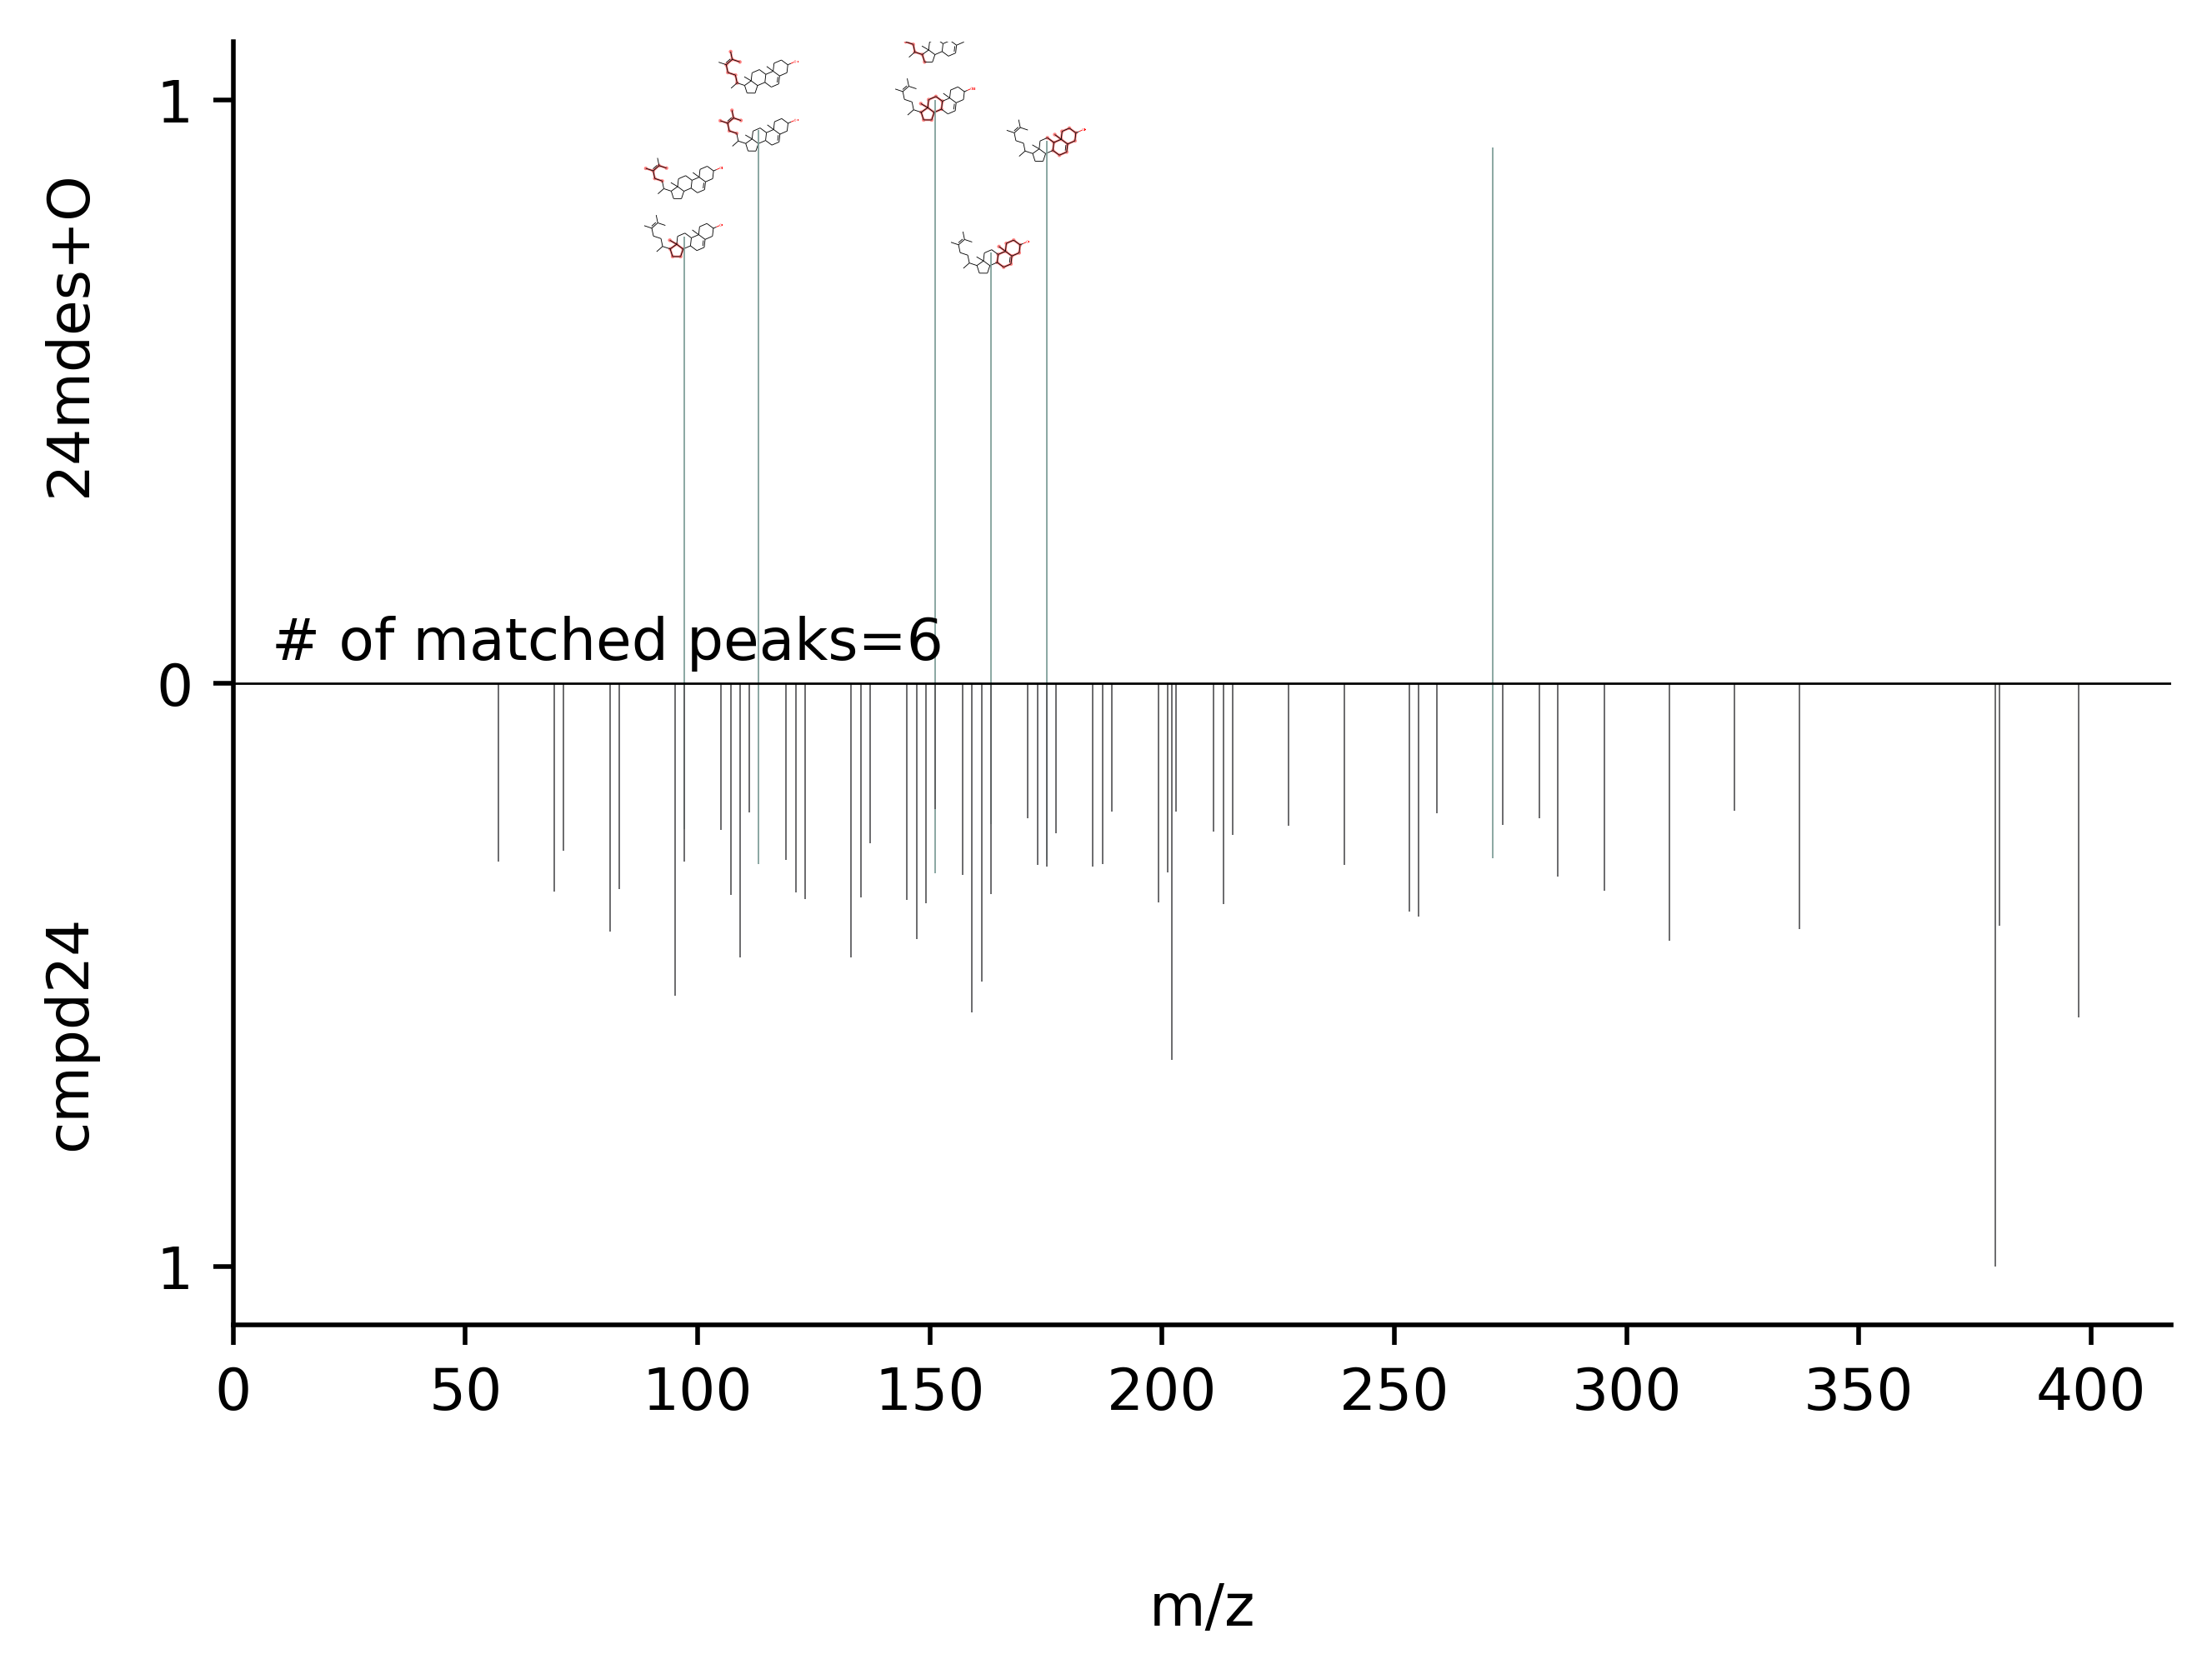

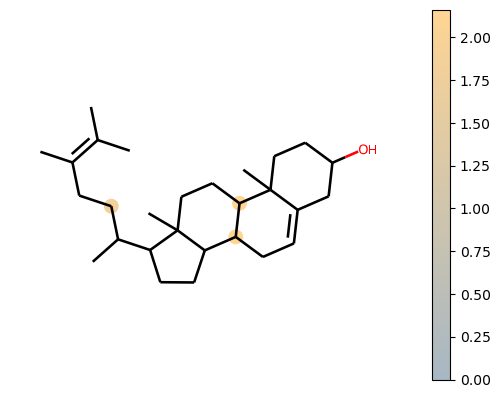

In [7]:
withanolide_modifinder('24mdes+H2O', 'cmpd24+H2O', '+O', 0.3, mz_cutoff=200) # [M+H]+ gives better peak coverage than [M+H-H2O]+

Covered peak: 113.09605, 1.00
Covered peak: 177.12764, 0.51
Covered peak: 165.12802, 0.35
Covered peak: 191.14320, 0.31
Covered peak: 163.11159, 0.10


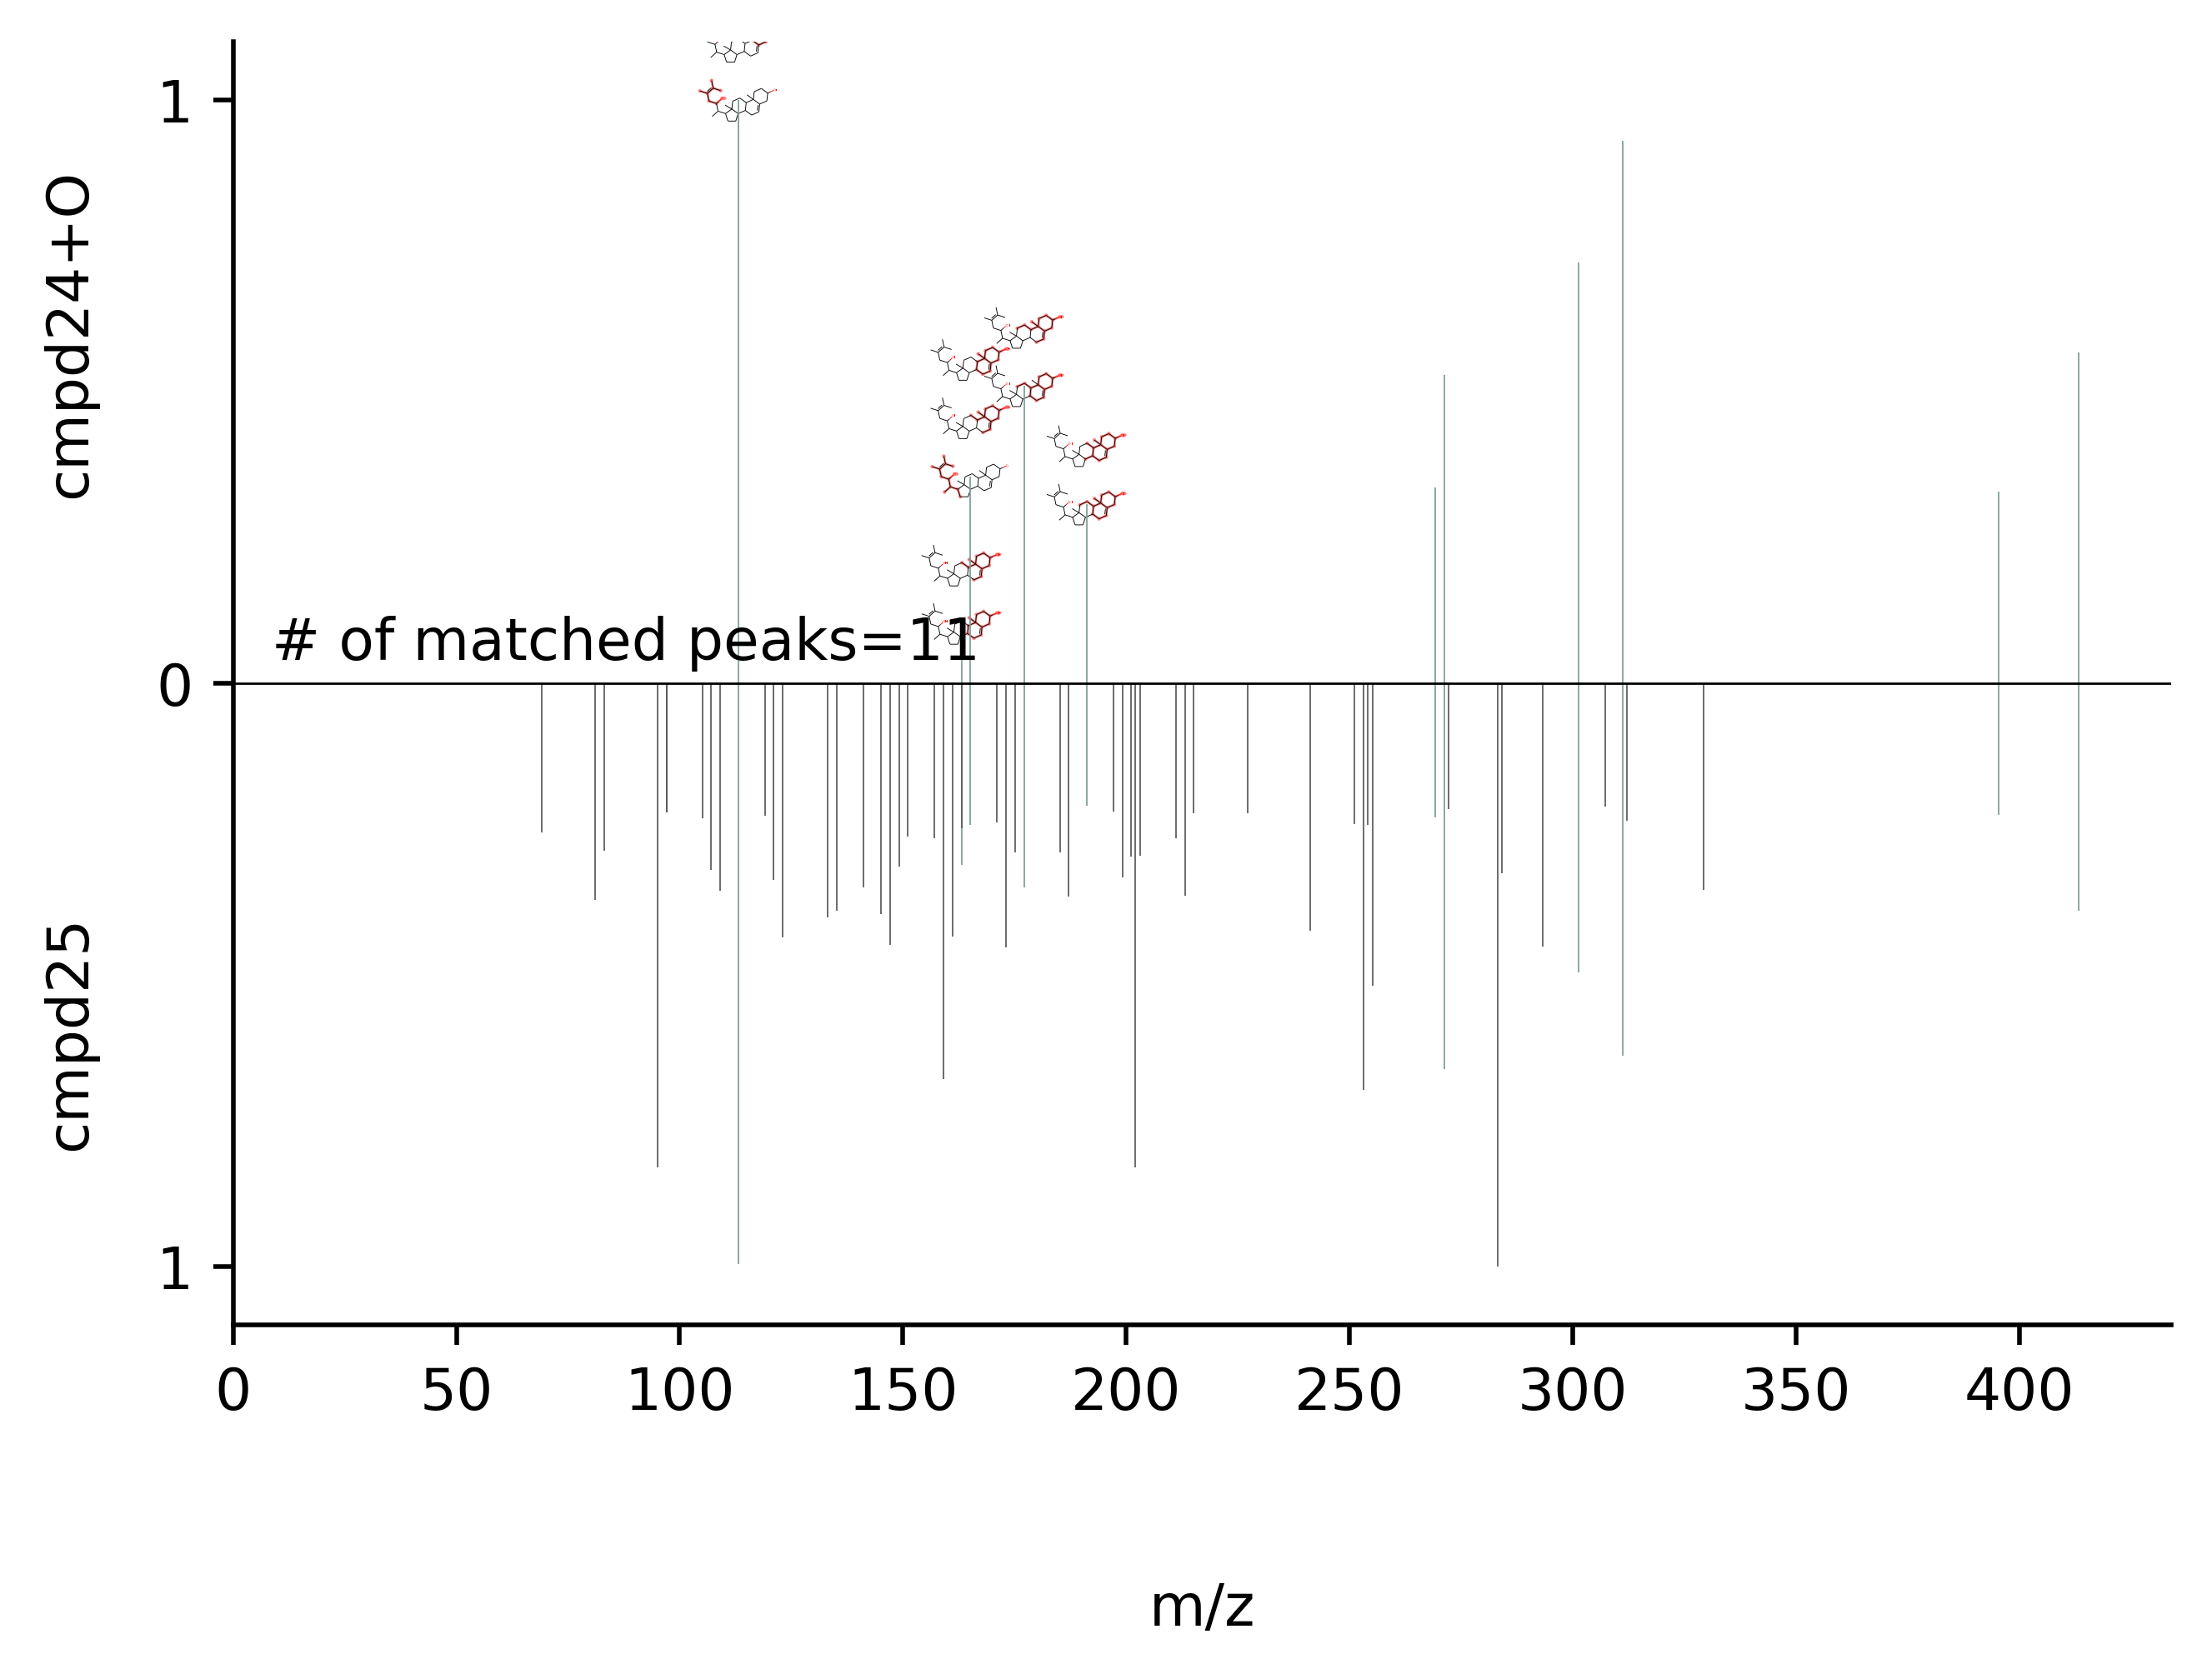

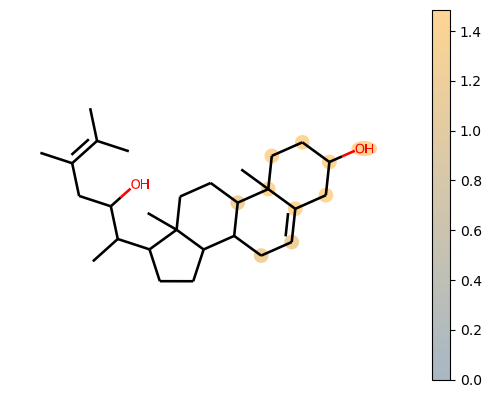

In [8]:
withanolide_modifinder('cmpd24', 'cmpd25', '+O', .25, mz_cutoff=200)

Covered peak: 173.09589, 0.51
Covered peak: 149.09608, 0.50
Covered peak: 175.11169, 0.12
Covered peak: 113.09599, 0.09


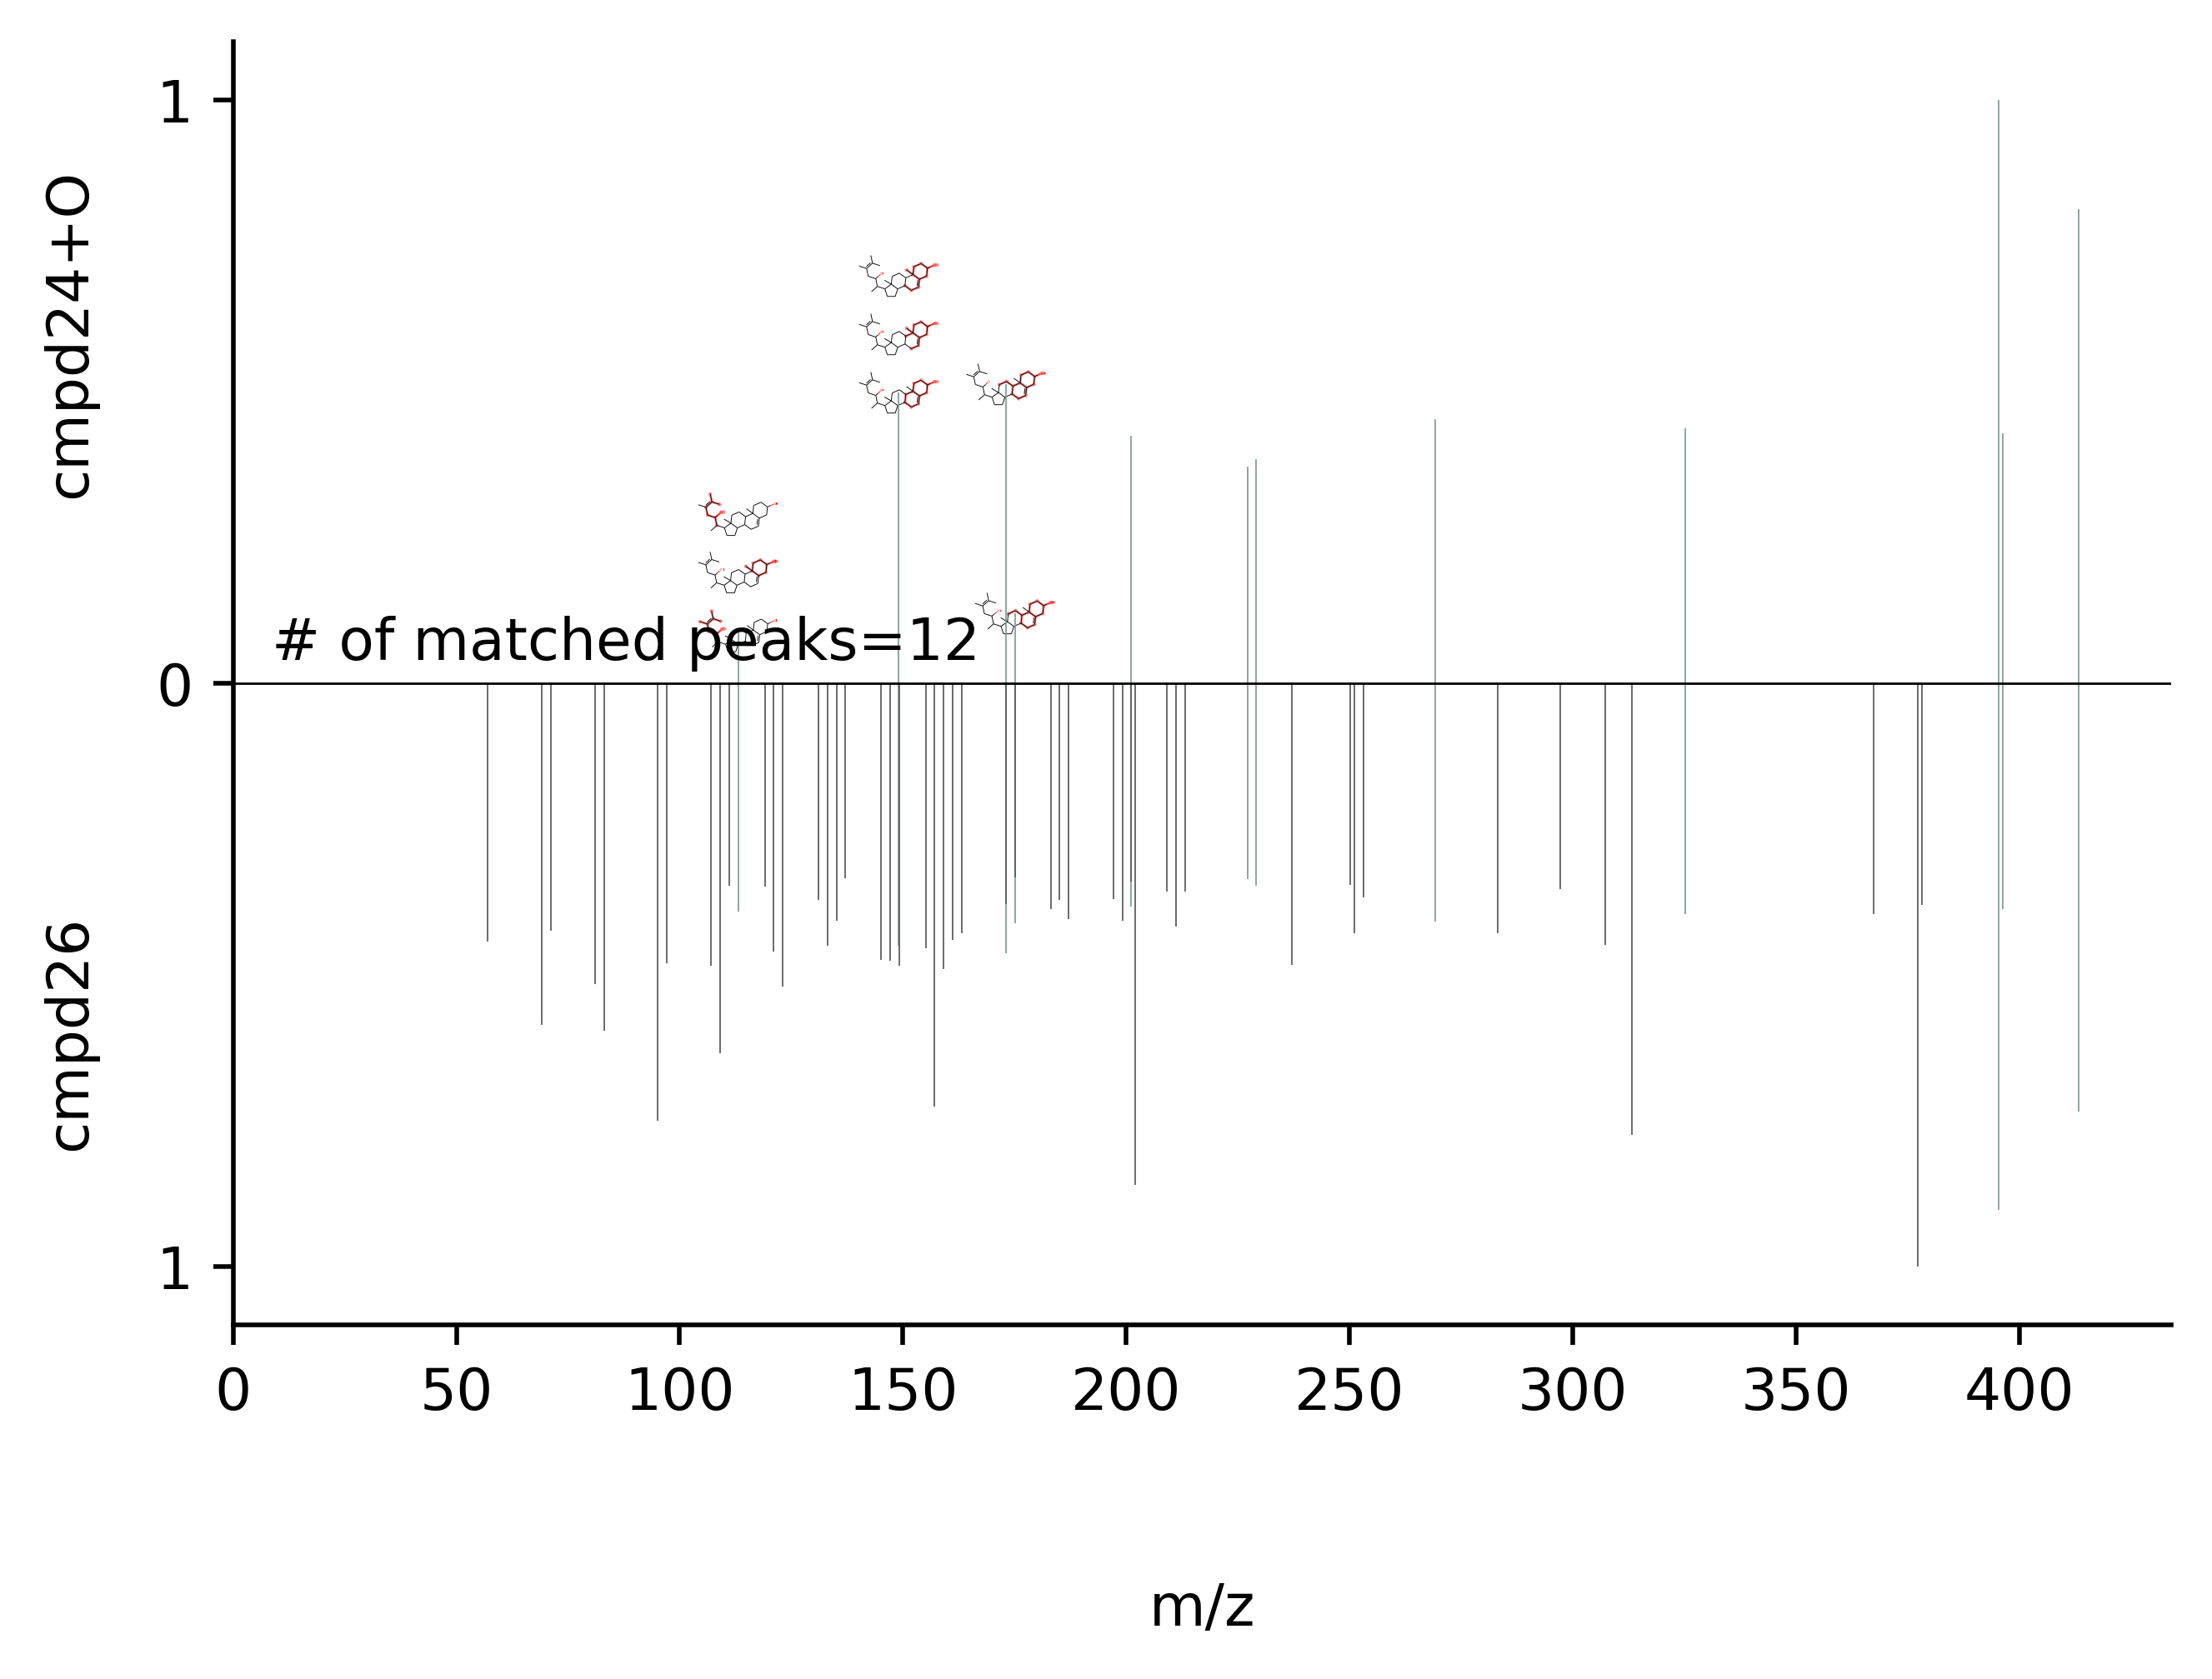

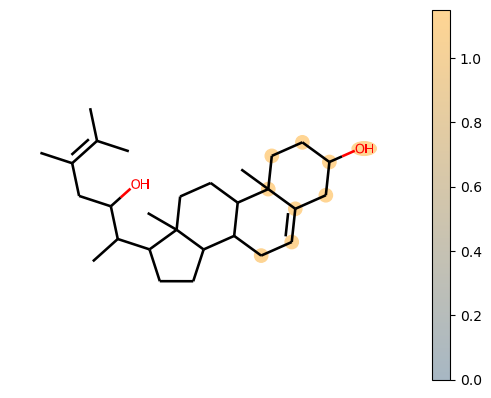

In [9]:
withanolide_modifinder('cmpd24', 'cmpd26', '+O', 0.1, mz_cutoff=200)

Covered peak: 111.08031, 1.00
Covered peak: 139.11139, 0.33
Covered peak: 137.09589, 0.28
Covered peak: 177.12831, 0.28


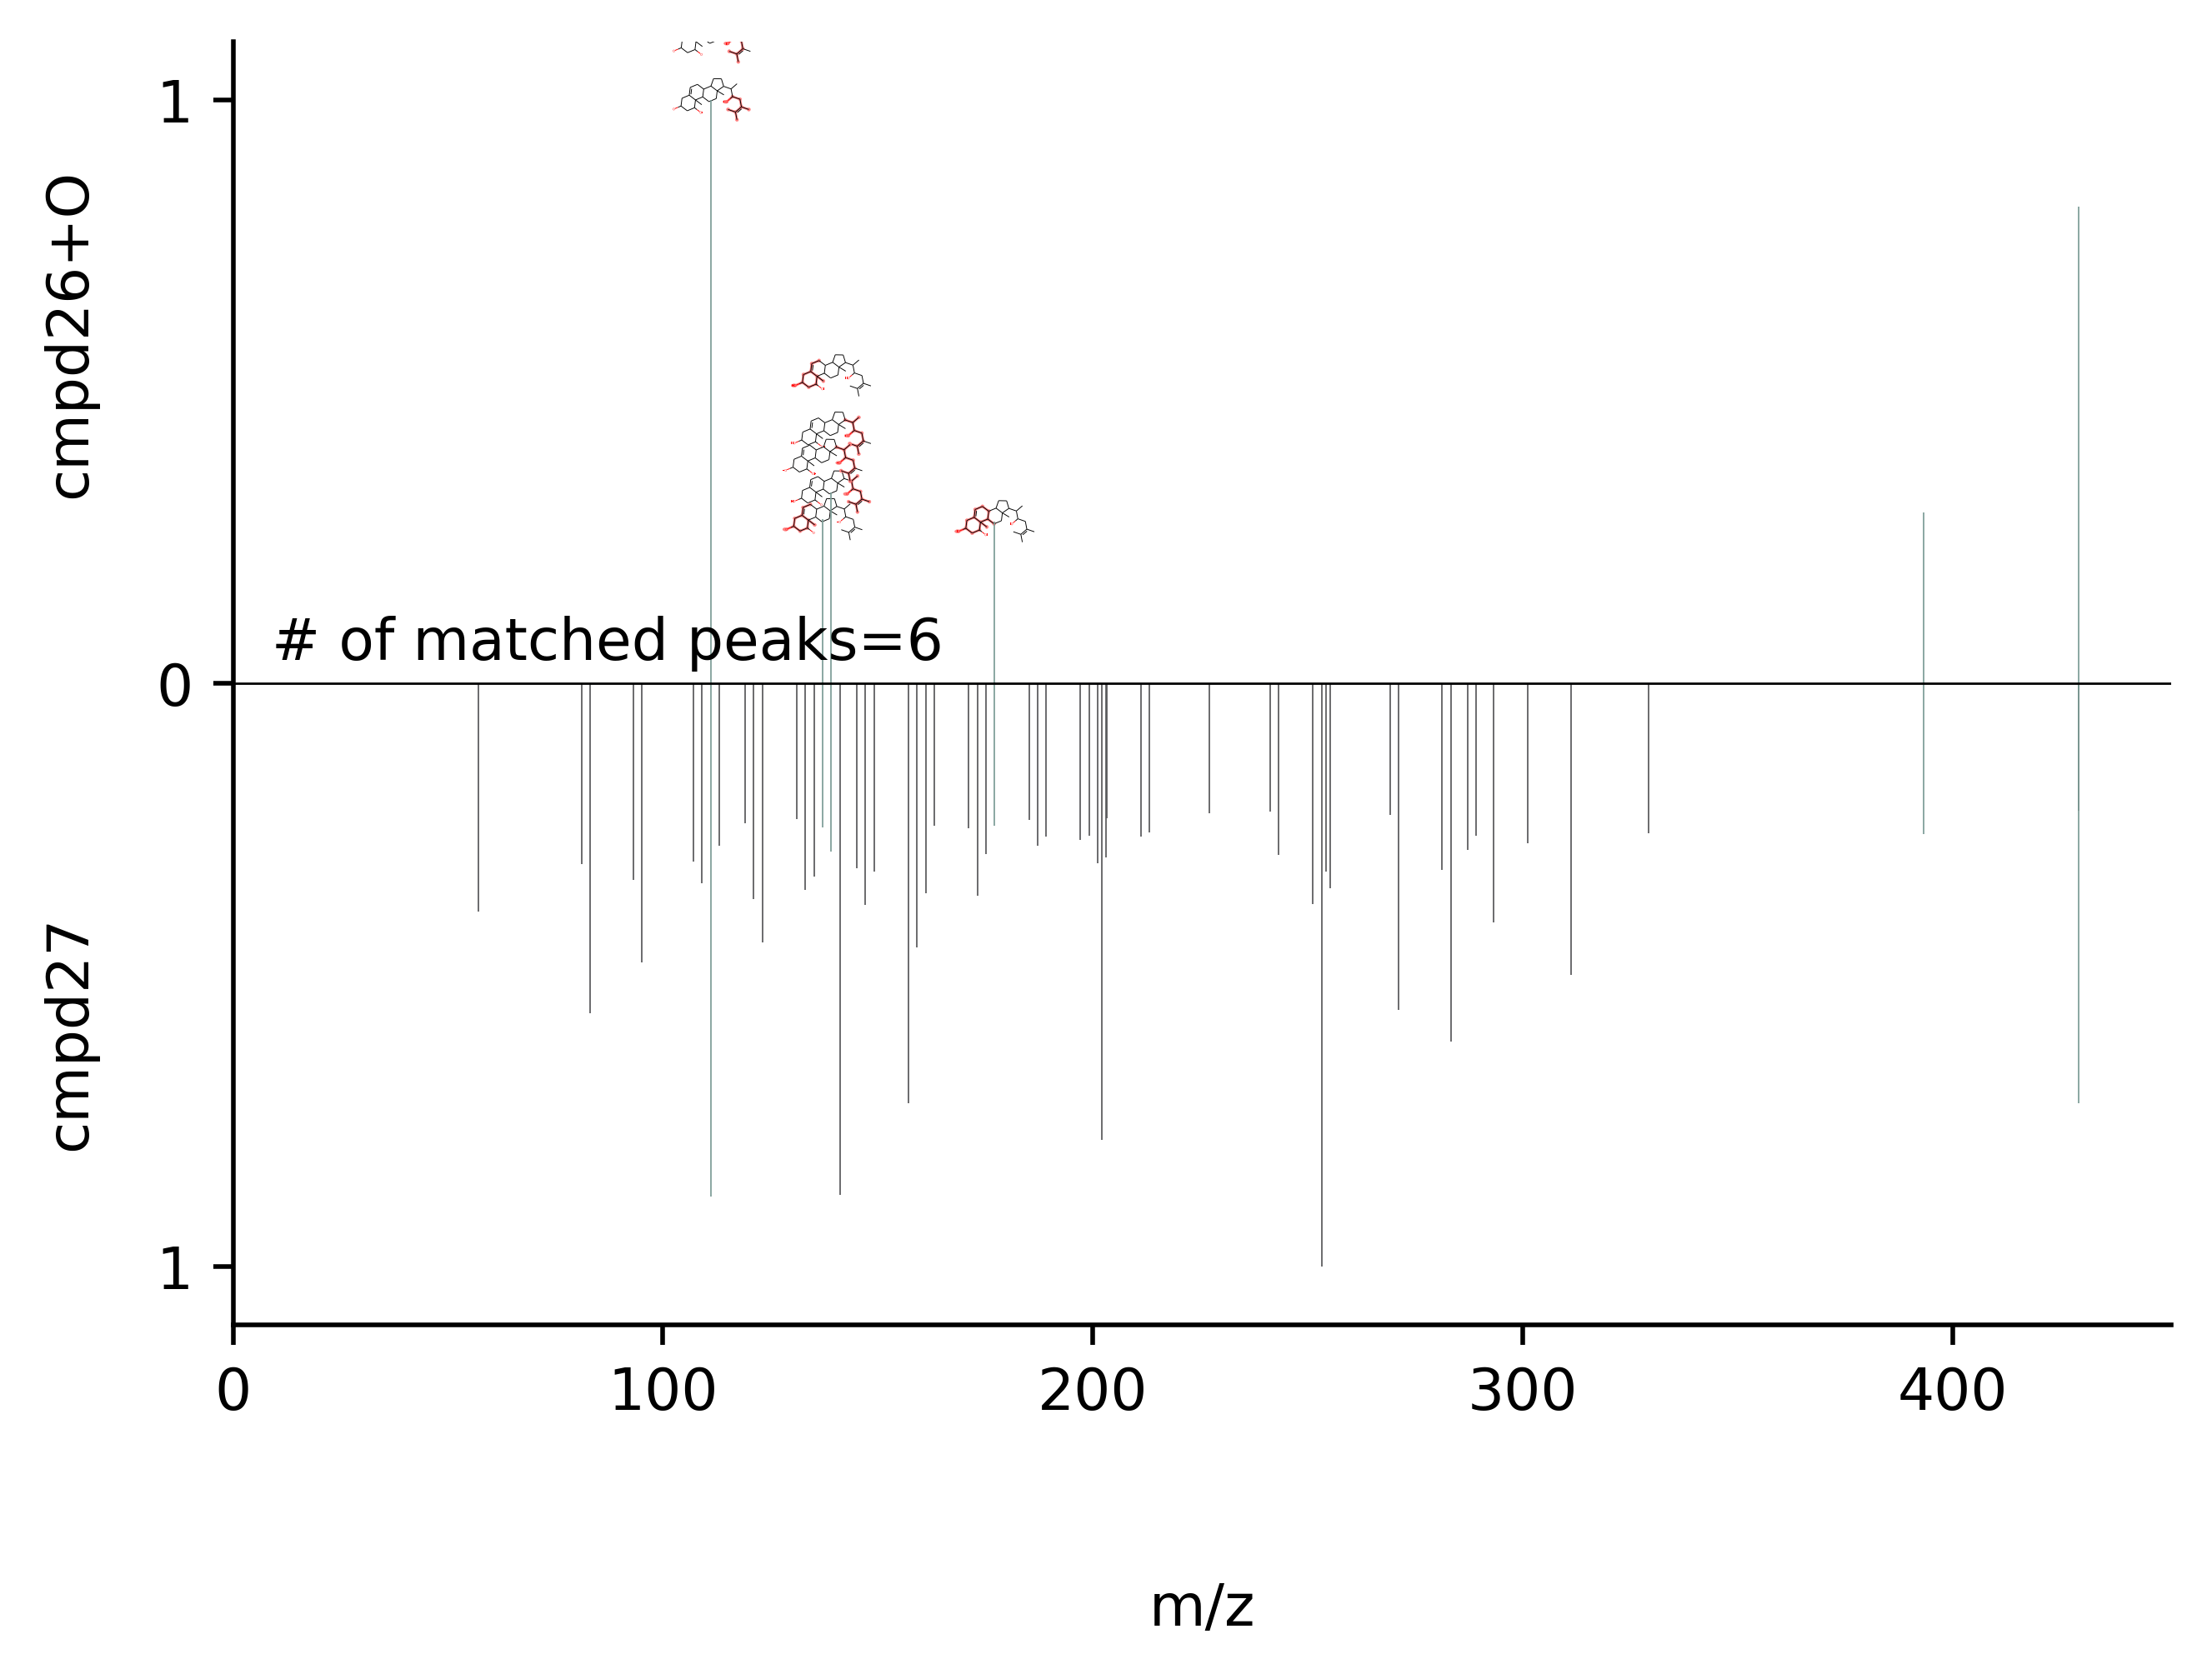

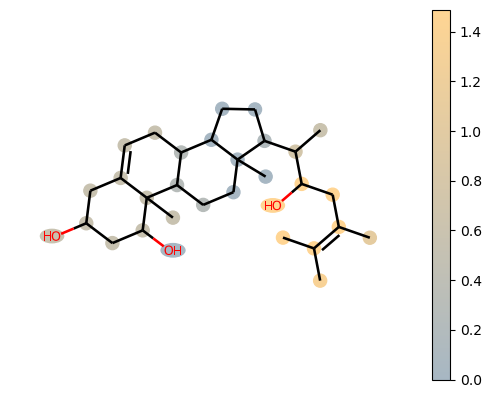

In [10]:
withanolide_modifinder('cmpd26', 'cmpd27', '+O', 100, mz_cutoff=200)

Uncovered peak: 183.11664, 0.87
Uncovered peak: 155.08525, 0.60
Uncovered peak: 195.11690, 0.53
Covered peak: 169.10014, 0.38
Uncovered peak: 139.11177, 0.34
Uncovered peak: 175.11188, 0.33
Uncovered peak: 197.13266, 0.32
Covered peak: 121.10093, 0.30
Uncovered peak: 157.10107, 0.26
Covered peak: 93.06995, 0.14
Uncovered peak: 185.13167, 0.12
Covered peak: 107.08543, 0.10
Covered peak: 171.11705, 0.09
Covered peak: 81.06987, 0.08
Covered peak: 131.08539, 0.08
Covered peak: 119.08543, 0.04
Uncovered peak: 199.14803, 0.03
Covered peak: 133.10117, 0.00


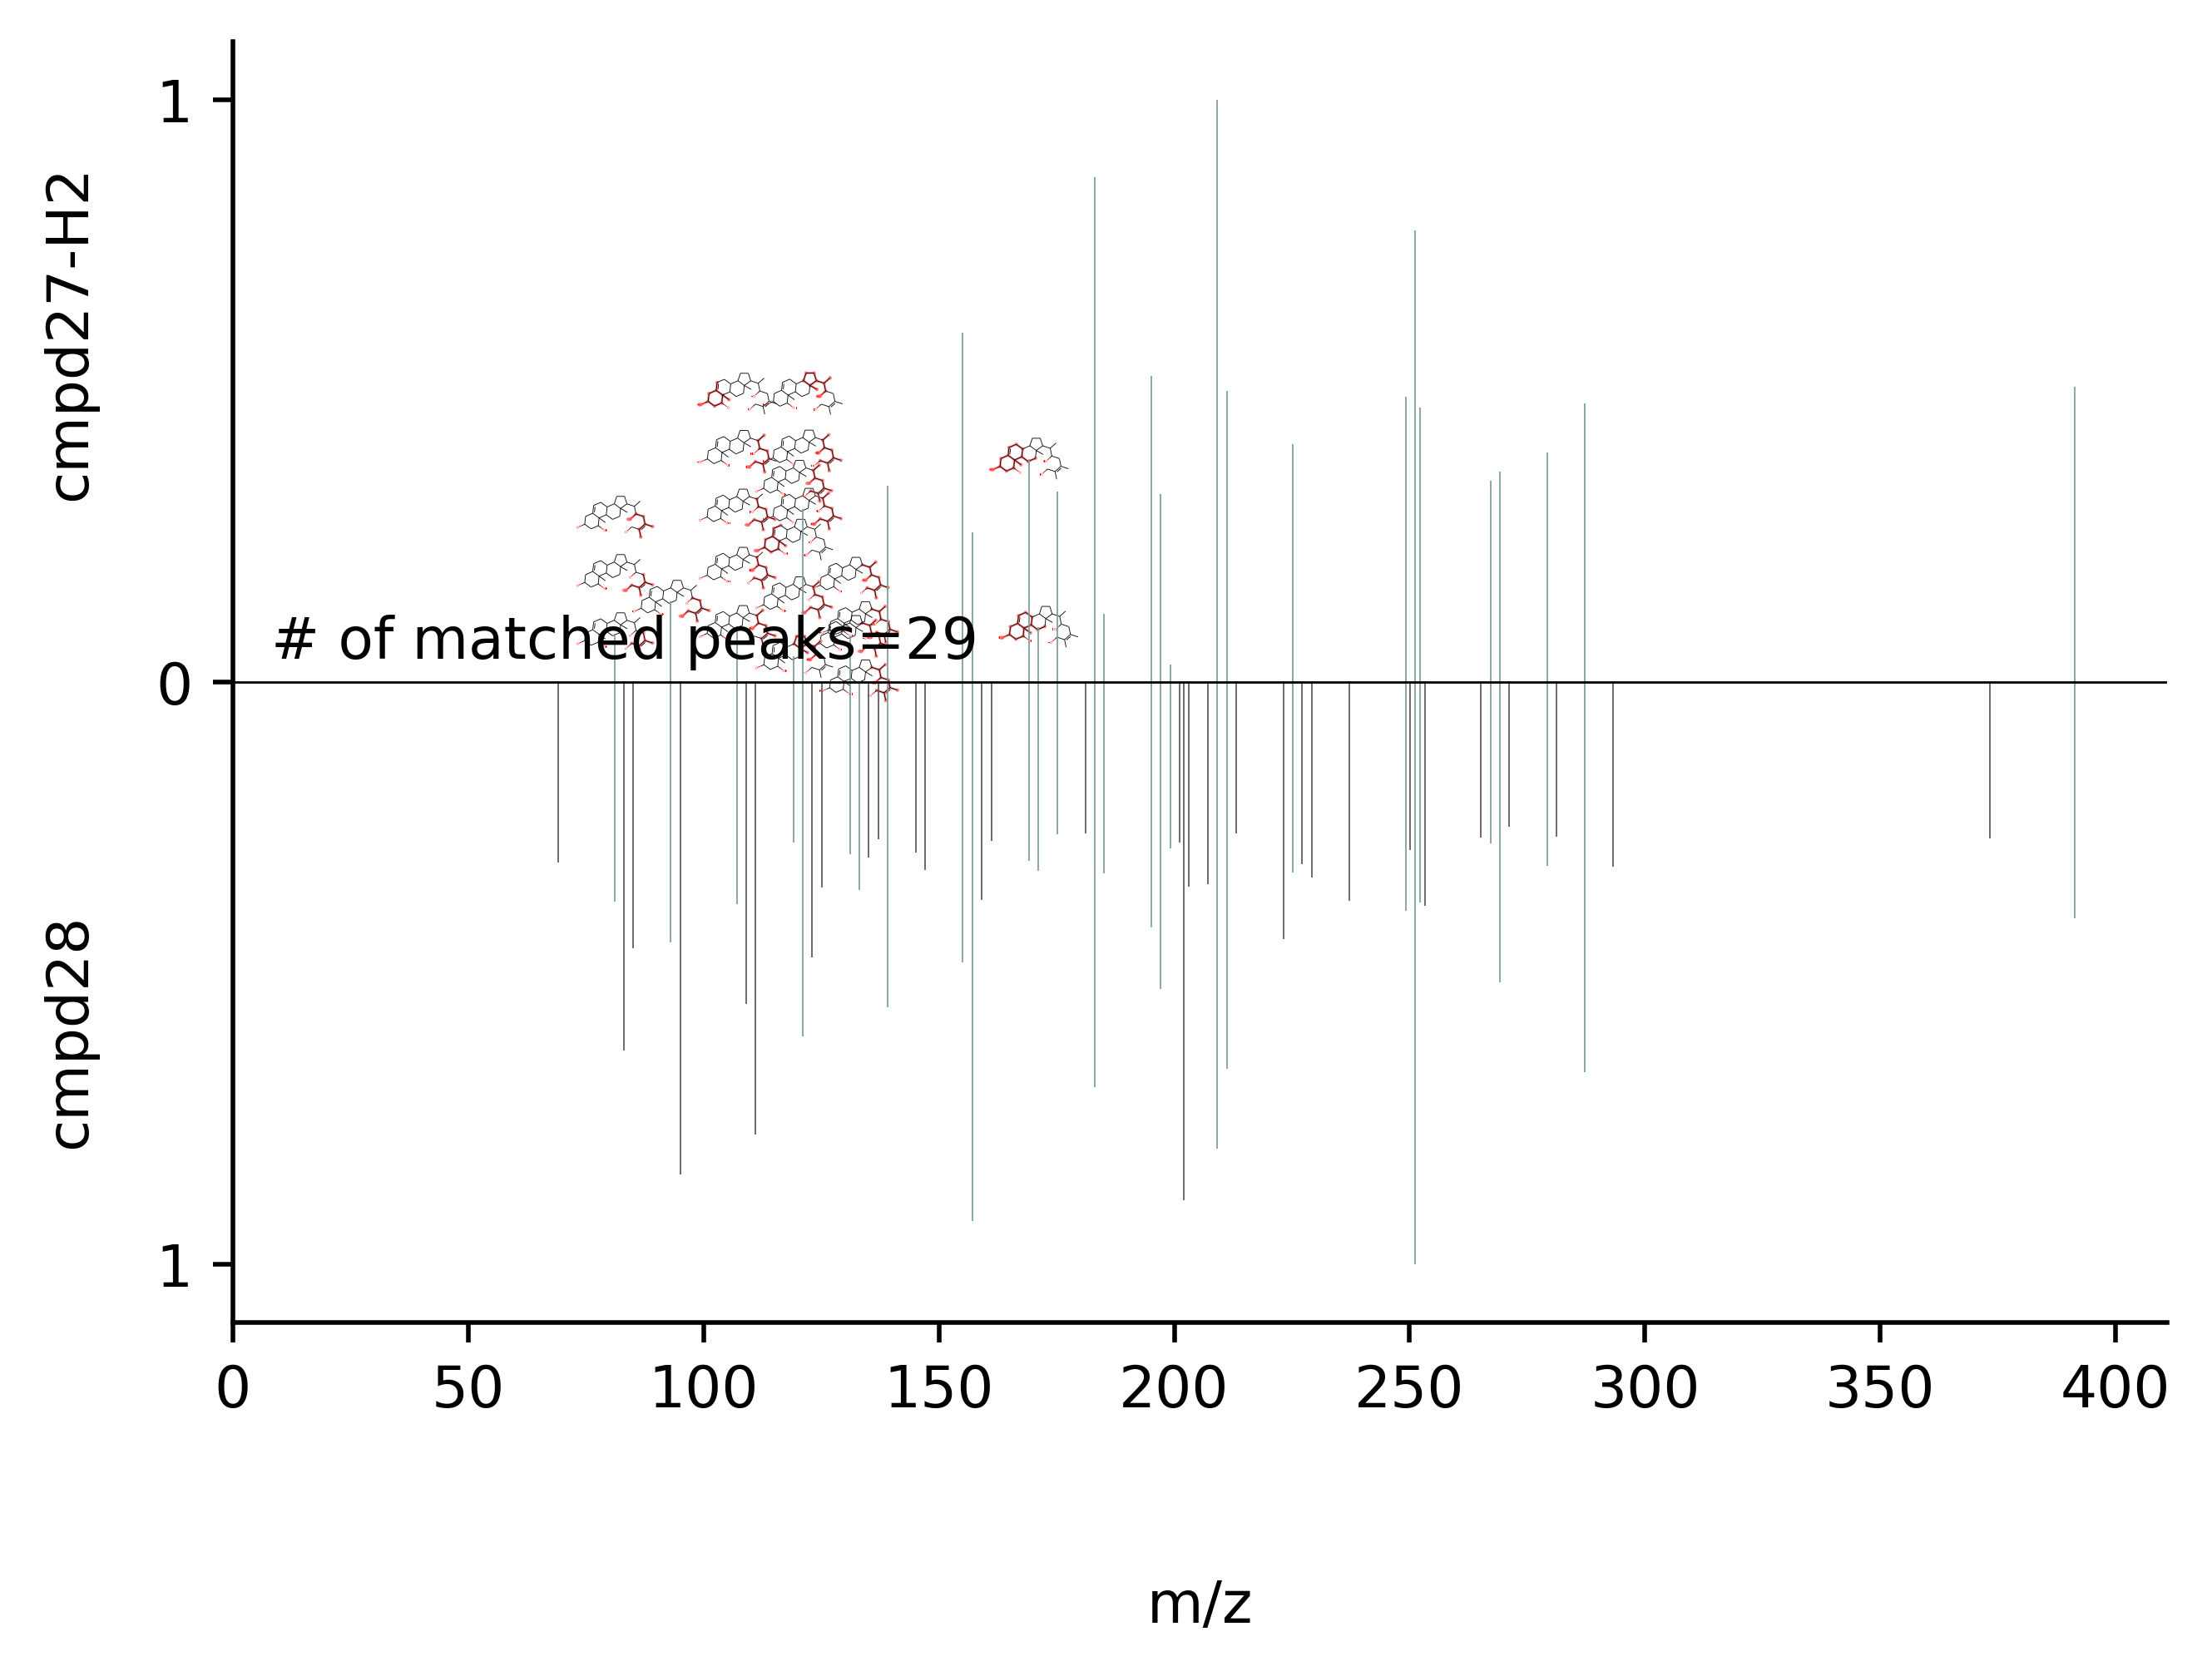

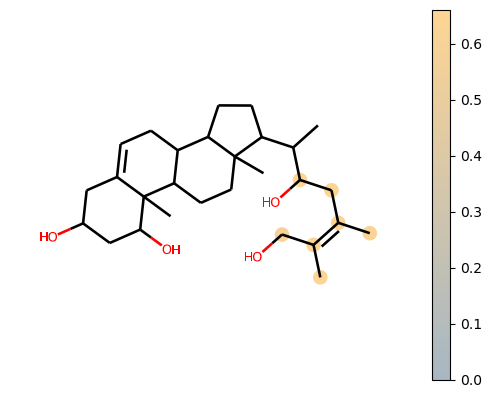

In [11]:
withanolide_modifinder('cmpd27', 'cmpd28', '-H2', 0.1, mz_cutoff=200)#0.3)

Covered peak: 137.09578, 1.00
Uncovered peak: 143.08548, 0.63
Uncovered peak: 159.11699, 0.22
Uncovered peak: 157.10112, 0.19
Uncovered peak: 145.10097, 0.14
Uncovered peak: 135.11725, 0.05


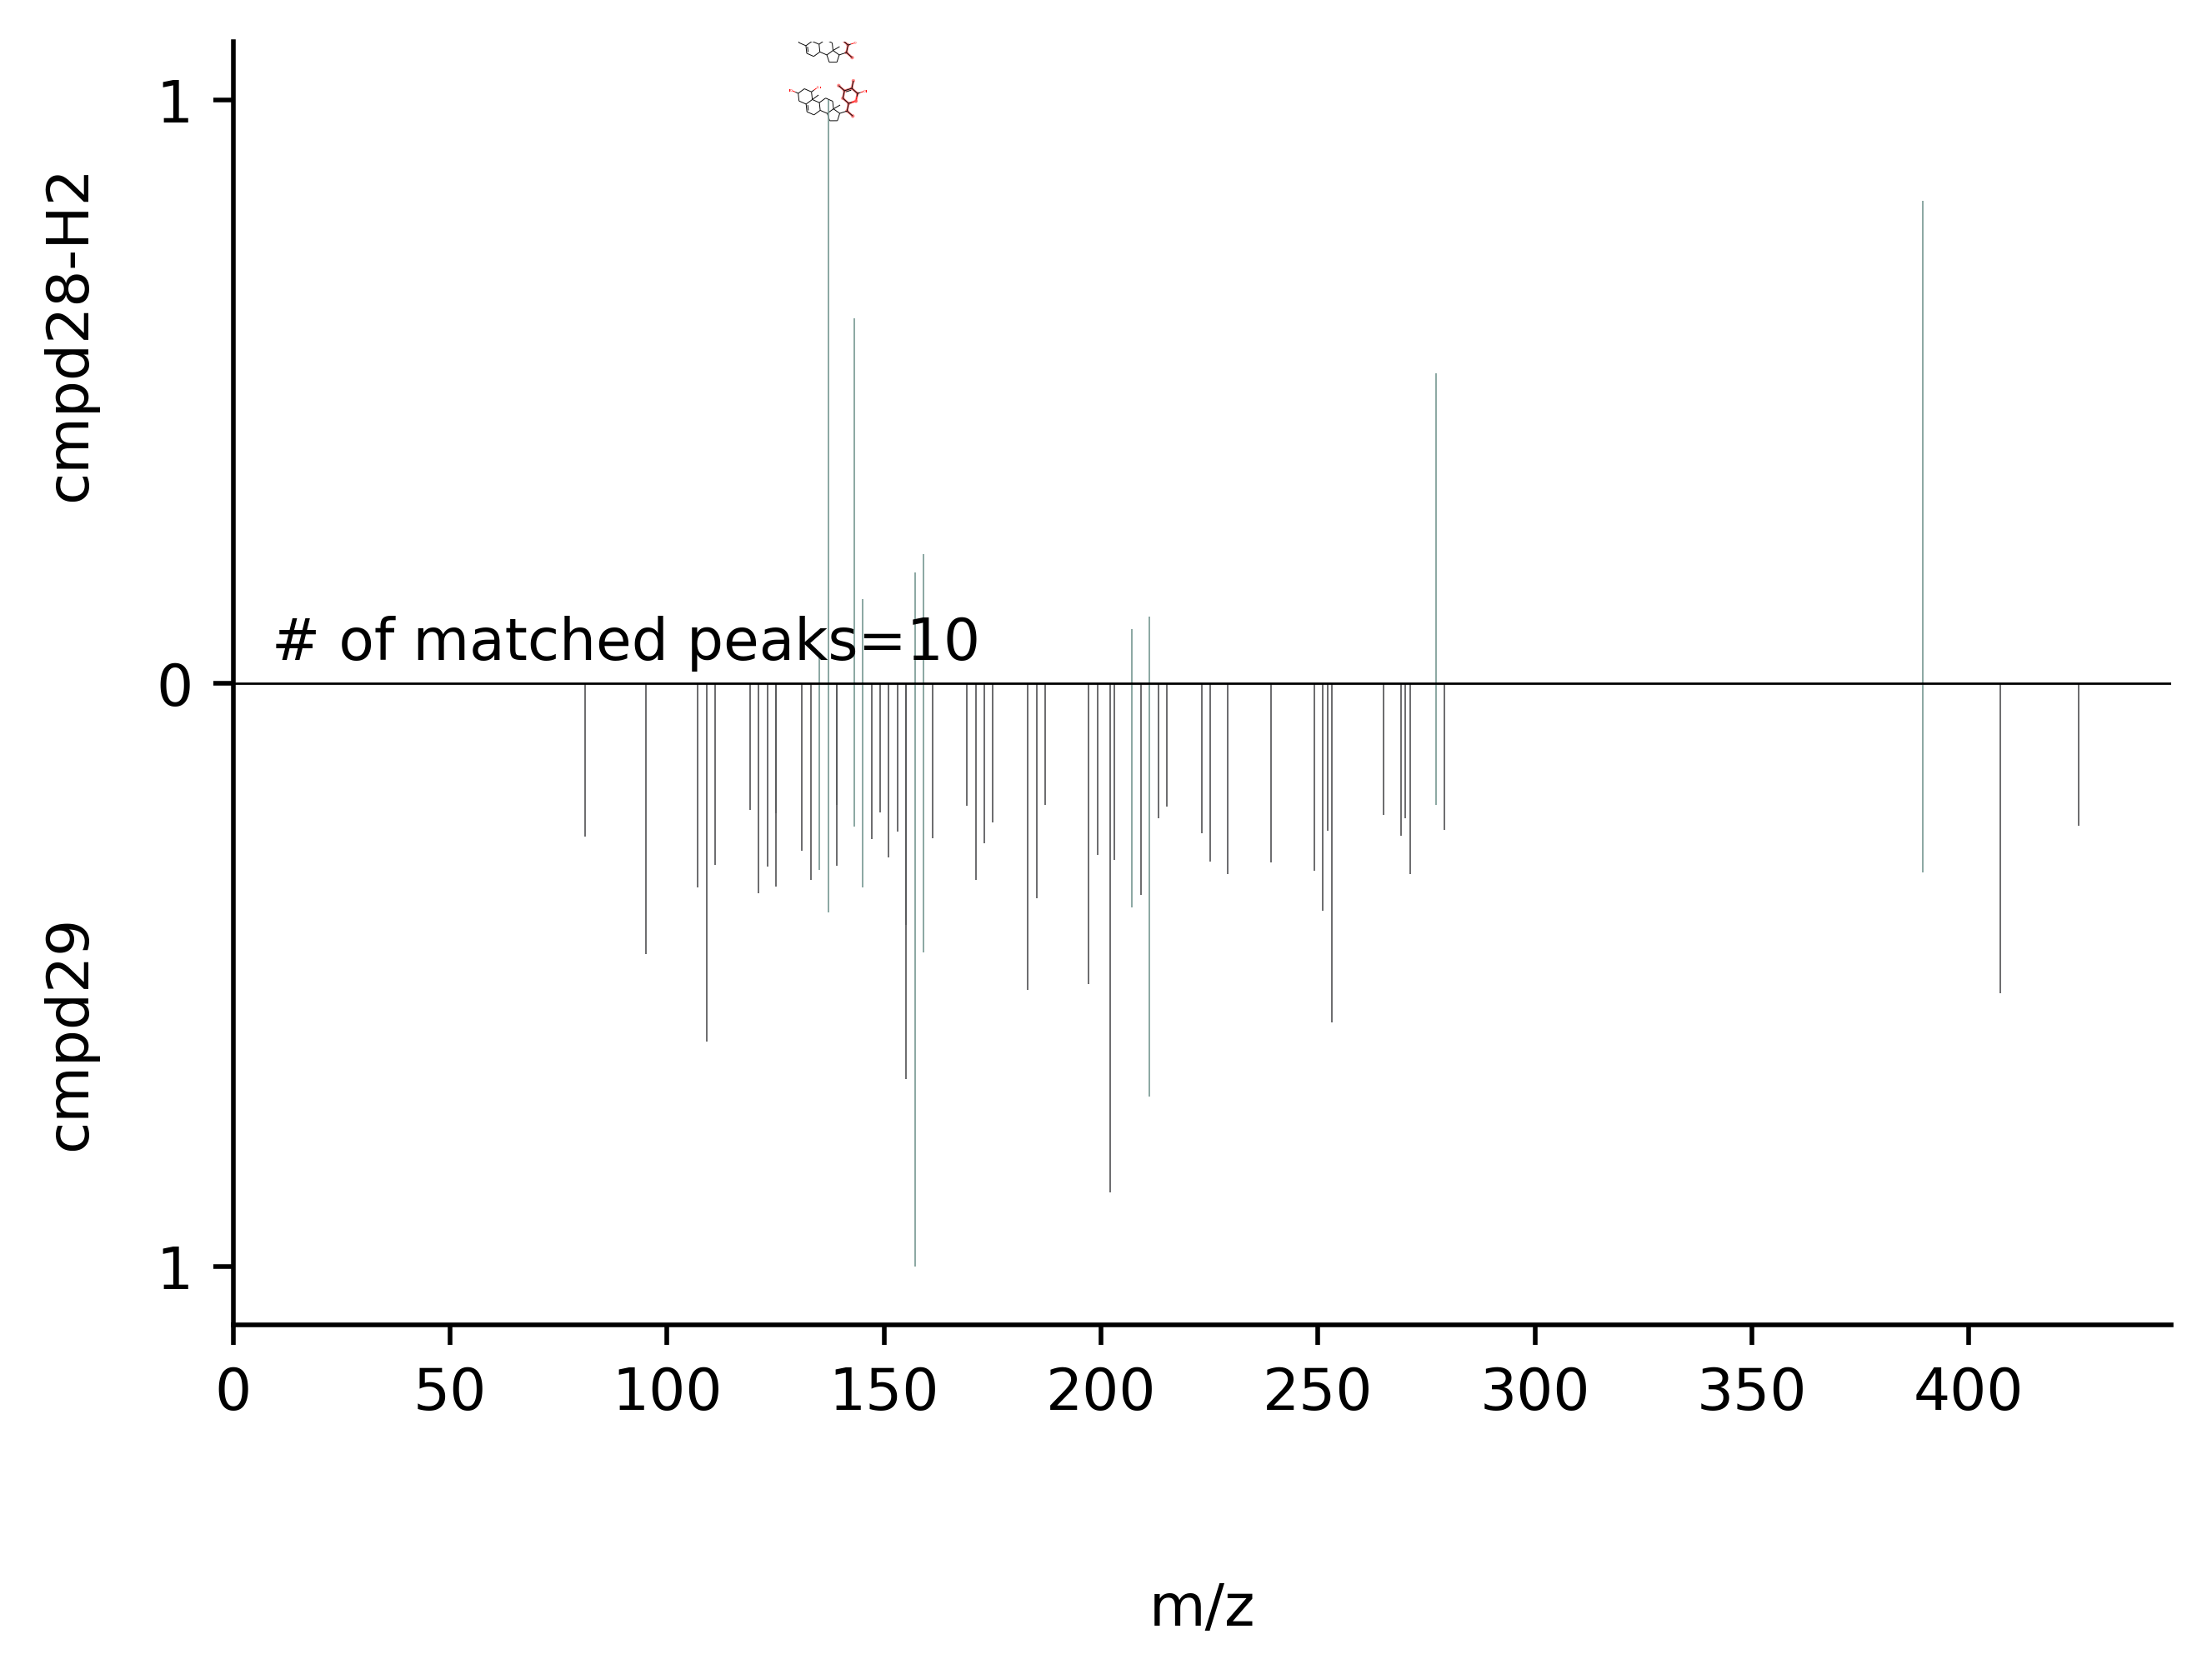

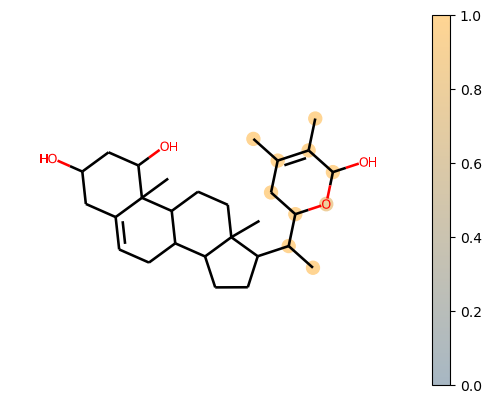

In [12]:
withanolide_modifinder('cmpd28+H2O', 'cmpd29', '-H2', 0.25, mz_cutoff=200)#0.3)